In [3]:
import numpy as np
import xarray as xr
import netCDF4 
import MITgcmutils as mit
import glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import cmocean
from matplotlib.colors import TwoSlopeNorm

import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter,LongitudeFormatter

from geopy.distance import great_circle
from scipy.spatial import cKDTree
from numba import njit



In [4]:
@njit(cache=True)
def lonlat_to_xyz(lon, lat):
    """経度・緯度を3次元座標に変換"""
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)  # 度からラジアンに変換
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

# @njit(cache=True)
def calculate_top_l_indices_and_norms_ckdtree(XCYC1, XCYC2, l):
    """
    XCYC2 の各点に対して、XCYC1 からノルムが小さい順に l 点のインデックスとノルムを計算（cKDTree を使用）。
    """
    # XCYC1 を3次元座標に変換して平坦化
    m, n = XCYC1.shape[:2]
    flattened_XCYC1 = XCYC1.reshape(-1, 2)
    points_xyz = np.array([lonlat_to_xyz(lon, lat) for lon, lat in flattened_XCYC1])

    # cKDTree を構築
    tree = cKDTree(points_xyz)

    # 結果を格納する配列を初期化
    top_l_indices = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l, 2), dtype=int)
    top_l_norms = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l))  # ノルムを格納

    # 各点を探索
    for i in range(XCYC2.shape[0]):
        for j in range(XCYC2.shape[1]):
            lon_query, lat_query = XCYC2[i, j, :]  # 経度、緯度を取得
            x_query, y_query, z_query = lonlat_to_xyz(lon_query, lat_query)

            # 最近傍探索
            distances, indices = tree.query([x_query, y_query, z_query], k=l)

            # インデックスを 2D の形状に変換
            if l == 1:  # l=1 の場合、スカラーが返るので処理を分岐
                indices = [indices]  # リスト化
                distances = [distances]  # リスト化

            unraveled_indices = np.unravel_index(indices, (m, n))

            for k in range(l):
                # インデックスを格納
                top_l_indices[i, j, k, :] = [unraveled_indices[0][k], unraveled_indices[1][k]]

            # ノルムを計算（geopy を使用）
            for k in range(l):
                lon1, lat1 = XCYC1[top_l_indices[i, j, k, 0], top_l_indices[i, j, k, 1]]
                lon2, lat2 = XCYC2[i, j, 0], XCYC2[i, j, 1]

                top_l_norms[i, j, k] = great_circle((lat1, lon1), (lat2, lon2)).kilometers

    return top_l_indices, top_l_norms


@njit(cache=True)
def regrid_data(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p=2.):
    """
    XCYC2 の各点に対応する data の値を IDW（逆距離加重法）で内挿。

    Args:
        XCYC1 (ndarray): 元の座標データ (形状: [m, n, 2])
        XCYC2 (ndarray): 対応する座標データ (形状: [p, q, 2])
        top_l_indices (ndarray): 最近傍 l 点のインデックス (形状: [p, q, l, 2])
        top_l_norms (ndarray): 最近傍 l 点のノルム (形状: [p, q, l])
        data (ndarray): 元データ (例: SSS) (形状: [m, n])
        p (float): 重み計算のパラメータ（デフォルトは 1.）

    Returns:
        regridded_data (ndarray): 変換後の座標 XCYC2 上に内挿されたデータ (形状: [p, q])
    """
    # 結果を格納する配列を初期化
    regridded_data = np.empty((XCYC2.shape[0], XCYC2.shape[1]))

    l = top_l_indices.shape[2]  # 最近傍点の数
    
    # データ内挿処理
    for i in range(XCYC2.shape[0]):  # XCYC2 の 1 軸目
        for j in range(XCYC2.shape[1]):  # XCYC2 の 2 軸目
            
            # 条件: 最近傍のノルムが閾値未満の場合、その値を直接代入
            # if top_l_norms[i, j, 0] < 1.e-10: #when unit is deg, worked well(to some extent).
            if top_l_norms[i, j, 0] < 1.e-4: #when unit is kilomerter, worked well.


                idx_x, idx_y = top_l_indices[i, j, 0]
                regridded_data[i, j] = data[idx_x, idx_y]
                continue
            
            # 各点の重み付けと加算
            weighted_sum = 0.0
            weight_total = 0.0
            for k in range(l):
                weight = top_l_norms[i, j, k] ** -p
                idx_x, idx_y = top_l_indices[i, j, k]
                weighted_sum += data[idx_x, idx_y] * weight
                weight_total += weight
            
            # 正規化（重みの合計で割る）
            regridded_data[i, j] = weighted_sum / (weight_total + 1.e-15) #when unit is deg, worked well.


    return regridded_data


1. 地形データ

In [5]:
fileloc_bathy = '/home/tsuribeh/Forcing_data/bathymetries/Straume_2020/'


In [6]:
#fileloc of input folder to use 
fileloc_to_write_atm ='/home/tsuribeh/MITgcm/cases_tsuribeh_master/Ex3.cpl_CTRL/input_atm/'
fileloc_to_write_ocn ='/home/tsuribeh/MITgcm/cases_tsuribeh_master/Ex3.cpl_CTRL/input_ocn/'
fileloc_to_write_cpl ='/home/tsuribeh/MITgcm/cases_tsuribeh_master/Ex3.cpl_CTRL/input_cpl/'




In [7]:
#import bathymetry(lonlat grid)

bathy_ds = xr.load_dataset(fileloc_bathy+'paleobathy-topo_36.00Ma_Straume_et_al.nc')

In [8]:
#make grid data of bathy(lonlat)

c =5 #Straume every 0.5 deg.
lon_ = np.array(bathy_ds['lon'][::c])#Straume
lat_ = np.array(bathy_ds['lat'][::c])#Straume

lon,lat = np.meshgrid(lon_,lat_)
lonlat = np.stack([lon,lat],axis=2)

#load raw bathy data
bathytopo_raw = np.array(bathy_ds['z'][::c,::c]).astype('float')

# mask_bathy_raw= bathy_raw > 0.
# bathy_raw[mask_bathy_raw] = np.nan
# bathy_raw[bathy_raw >0.] = np.nan


In [9]:
bathytopo_raw


array([[  689.97406006,   689.97406006,   689.97406006, ...,
          689.97406006,   689.97406006,   689.97406006],
       [  393.10296631,   396.02420044,   397.34051514, ...,
          413.51977539,   403.60775757,   393.10296631],
       [   14.72273445,    16.21475983,    15.40306091, ...,
           19.35780716,    17.97322655,    14.72273445],
       ...,
       [-3952.3527832 , -3899.40454102, -3891.01416016, ...,
        -3882.84814453, -3900.86206055, -3952.3527832 ],
       [-4470.46289062, -4459.04443359, -4459.26025391, ...,
        -4458.44726562, -4458.63525391, -4470.46289062],
       [-4498.20654297, -4498.20654297, -4498.20654297, ...,
        -4498.20654297, -4498.20654297, -4498.20654297]])

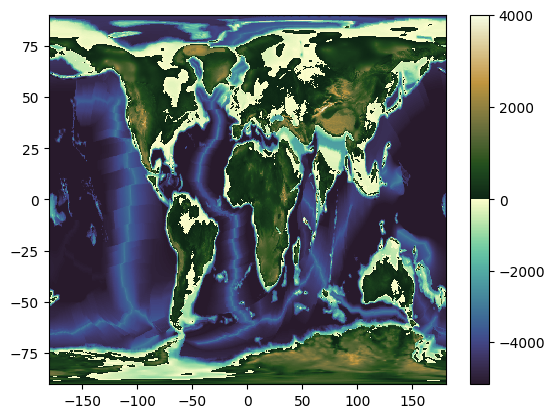

In [10]:
plt.pcolormesh(lon,lat,bathytopo_raw, cmap=cmocean.cm.topo, norm= TwoSlopeNorm(vcenter=0., vmin=-5200, vmax=4000))
plt.colorbar()

In [11]:
#リグリッド後の座標データがある場所
#Directory for cs grid
fileloc_csgrid = '/home/tsuribeh/MITgcm/cases_tsuribeh_bachelor/cpl_aim+ocn_cs32/rank_1/'
# CSグリッドデータの読み込み
XC = mit.mds.rdmds(fileloc_csgrid+'XC') #longitude at cell center
YC = mit.mds.rdmds(fileloc_csgrid+'YC') #latitude at cell center
XG = mit.mds.rdmds(fileloc_csgrid+'XG')
YG = mit.mds.rdmds(fileloc_csgrid+'YG')
# RC = mit.mds.rdmds(fileloc_csgrid+'RC')  # セル中心の深さ can be changed
# RF = mit.mds.rdmds(fileloc_csgrid+'RF')  # セル境界の深さ can be changed

XCYC = np.stack([XC,YC],axis=2)
XGYG = np.stack([XG,YG],axis=2)


In [12]:
DXC = mit.mds.rdmds(fileloc_csgrid+'DXC') #longitude at cell center
DYC = mit.mds.rdmds(fileloc_csgrid+'DYC') #longitude at cell center

DS = DXC * DYC # Area of each grid cell
DS.shape

(32, 192)

In [13]:
lon_
lat_

array([-90. , -89.5, -89. , -88.5, -88. , -87.5, -87. , -86.5, -86. ,
       -85.5, -85. , -84.5, -84. , -83.5, -83. , -82.5, -82. , -81.5,
       -81. , -80.5, -80. , -79.5, -79. , -78.5, -78. , -77.5, -77. ,
       -76.5, -76. , -75.5, -75. , -74.5, -74. , -73.5, -73. , -72.5,
       -72. , -71.5, -71. , -70.5, -70. , -69.5, -69. , -68.5, -68. ,
       -67.5, -67. , -66.5, -66. , -65.5, -65. , -64.5, -64. , -63.5,
       -63. , -62.5, -62. , -61.5, -61. , -60.5, -60. , -59.5, -59. ,
       -58.5, -58. , -57.5, -57. , -56.5, -56. , -55.5, -55. , -54.5,
       -54. , -53.5, -53. , -52.5, -52. , -51.5, -51. , -50.5, -50. ,
       -49.5, -49. , -48.5, -48. , -47.5, -47. , -46.5, -46. , -45.5,
       -45. , -44.5, -44. , -43.5, -43. , -42.5, -42. , -41.5, -41. ,
       -40.5, -40. , -39.5, -39. , -38.5, -38. , -37.5, -37. , -36.5,
       -36. , -35.5, -35. , -34.5, -34. , -33.5, -33. , -32.5, -32. ,
       -31.5, -31. , -30.5, -30. , -29.5, -29. , -28.5, -28. , -27.5,
       -27. , -26.5,

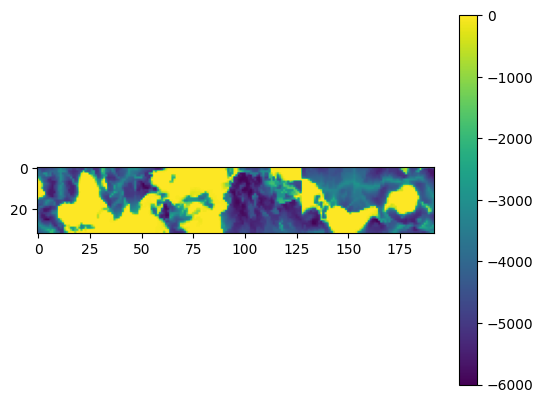

In [14]:
bathy_otehon = mit.readbin('/home/tsuribeh/MITgcm/verification/cpl_aim+ocn/rank_1/bathy_Hmin50.bin',(32,192), dataprec='float64')
plt.imshow(bathy_otehon)
plt.colorbar()

In [15]:
#compute indice and norm for regridding
# top_indices_XCYC_to_lonlat, top_norms_XCYC_to_lonlat = calculate_top_l_indices_and_norms_ckdtree(XCYC, lonlat, l=3)
top_indices_lonlat_to_XCYC, top_norms_lonlat_to_XCYC = calculate_top_l_indices_and_norms_ckdtree(lonlat, XCYC, l=9)

bathy_raw = bathytopo_raw.copy()
bathy_raw[bathy_raw>=-0.] = np.nan

bathy_data = regrid_data(lonlat,XCYC, top_indices_lonlat_to_XCYC,top_norms_lonlat_to_XCYC,bathy_raw,p=1.)
# bathytopo_data = regrid_data(lonlat,XCYC, top_indices_lonlat_to_XCYC,top_norms_lonlat_to_XCYC,bathytopo_raw,p=10.)

bathy_data[np.isnan(bathy_data)] = 0.

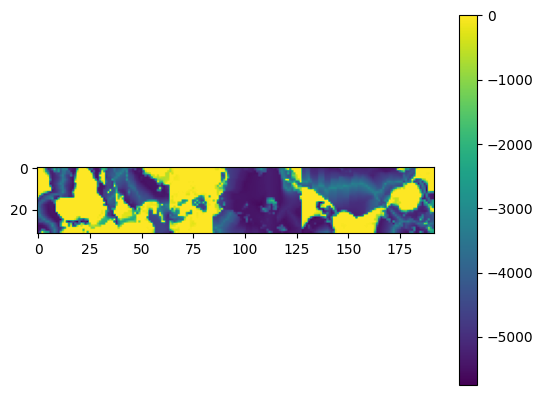

In [16]:
plt.imshow(bathy_data,vmax=0.
        #    , norm=TwoSlopeNorm(vmax=0.,vmin=-5200)
           )  # or shading='gouraud'
plt.colorbar()

水深がhFacMinDr_ocnより浅いところは0にする。

In [17]:
hFacMinDr_ocn=50.

# bathy_data[(-hFacMinDr_ocn<bathy_data) & (0. > bathy_data)] = -hFacMinDr_ocn
bathy_data[(-hFacMinDr_ocn<bathy_data) & (0. > bathy_data)] = -0.

# bathytopo_data[(-hFacMinDr_ocn<bathytopo_data) & (0. > bathytopo_data)] = -hFacMinDr_ocn


np.unique(bathy_data)


array([-5749.36397831, -5675.62445199, -5674.83076084, ...,
         -50.43984634,   -50.38276452,     0.        ])

#グリーンランド周辺の海峡を修正


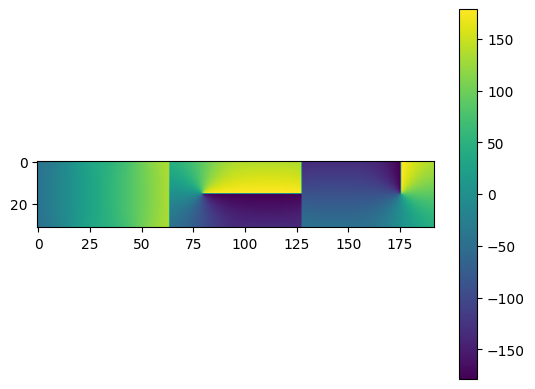

In [18]:
plt.imshow(XC)
plt.colorbar()

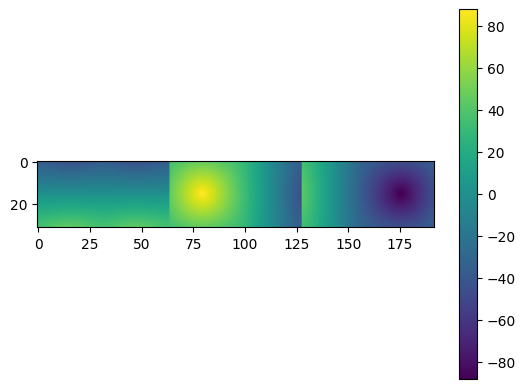

In [19]:
plt.imshow(YC)
plt.colorbar()

北極海周辺の経度に注意

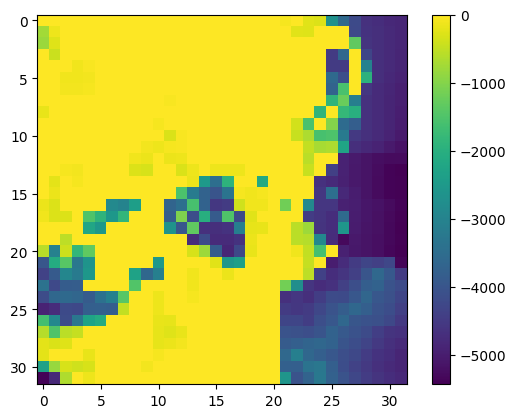

In [20]:
plt.imshow(bathy_data[:,64:96 ],vmax=0.
        #    , norm=TwoSlopeNorm(vmax=0.,vmin=-5200)
           )  # or shading='gouraud'
plt.colorbar()

In [21]:
# plt.imshow(bathytopo_data[:,64:80 ],vmax=0.
#         #    , norm=TwoSlopeNorm(vmax=0.,vmin=-5200)
#            )  # or shading='gouraud'
# plt.colorbar()

In [22]:
bathy_data[19,3+64:5+64] = -50. #GSR

bathy_data[16,9+64:11+64] = -120. #Fram Strait

bathy_data[23,7+64]  =(bathy_data[23+1,7+64]+bathy_data[23-1,7+64]+bathy_data[23,7+64+1]+bathy_data[23,7+64-1] )/4.#Davis Strait
bathy_data[24,8+64]  =(bathy_data[24+1,8+64]+bathy_data[24-1,8+64]+bathy_data[24,8+64+1]+bathy_data[24,8+64-1] )/4. #Davis Strait

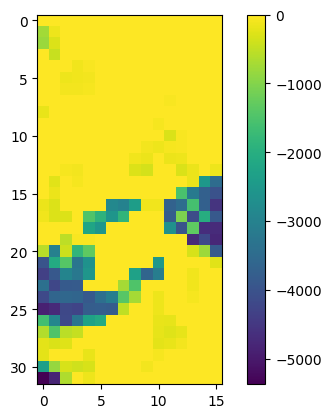

In [23]:
plt.imshow(bathy_data[:,64:80 ],vmax=0.

        #    , norm=TwoSlopeNorm(vmax=0.,vmin=-5200)
           )  # or shading='gouraud'
plt.colorbar()

#アフリカ-イベリア半島を開通

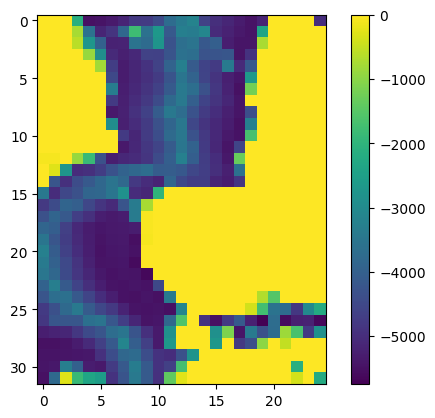

In [24]:
plt.imshow(bathy_data[:,0:25 ],vmax=0.
        #    , norm=TwoSlopeNorm(vmax=0.,vmin=-5200)
           )  # or shading='gouraud'
plt.colorbar()

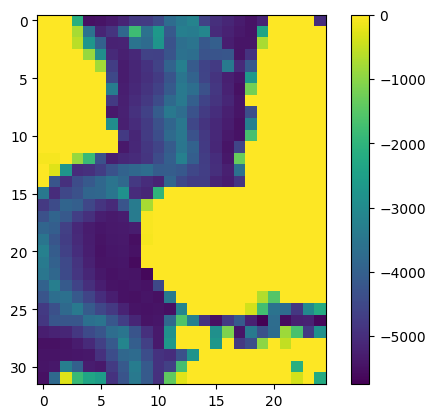

In [25]:
bathy_data[26,13] = (bathy_data[26,13-1] + bathy_data[26,13+1])/2.
plt.imshow(bathy_data[:,0:25 ],vmax=0.
        #    , norm=TwoSlopeNorm(vmax=0.,vmin=-5200)
           )  # or shading='gouraud'
plt.colorbar()

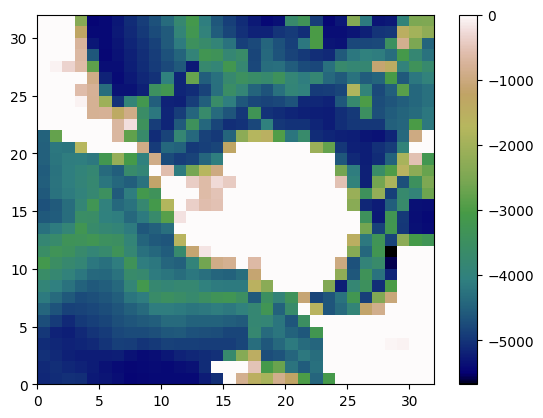

In [26]:
plt.pcolormesh(bathy_data[:,-32:],cmap='gist_earth')
plt.colorbar()

In [27]:
from scipy.ndimage import label, binary_propagation

# 仮定：bathymetry = 海底の標高 [m]（例：0より小さいと海）
wet_mask = (bathy_data < 0)  # shape = (lat, lon)

# 外洋に接続している海を識別するための "種"：端に接している海
seed = np.zeros_like(wet_mask, dtype=bool)
# seed[0, :] = wet_mask[0, :]
# seed[-1, :] = wet_mask[-1, :]
# seed[:, 0] = wet_mask[:, 0]
# seed[:, -1] = wet_mask[:, -1]
# # seed[18,78] = wet_mask[18,78] #北極海
seed[-1,0] = wet_mask[-1,0]
seed[-1,-1] =wet_mask[-1,-1]
# Flood fill: 外洋に繋がる海を True に
mask_ocean = binary_propagation(seed, mask=wet_mask)


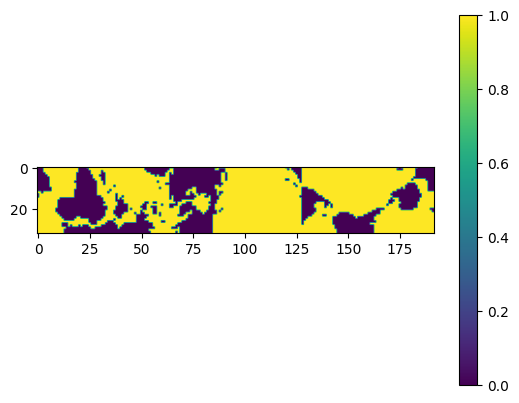

In [28]:
plt.imshow(mask_ocean)
plt.colorbar()

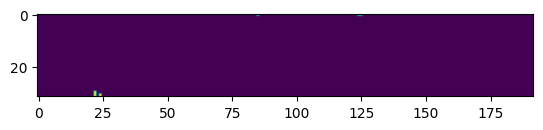

In [29]:
# 外洋に接続している海を識別するための "種"：端に接している海
seed_2 = np.zeros_like(wet_mask, dtype=bool)
seed_2[0, :] = wet_mask[0, :]
seed_2[-1, :] = wet_mask[-1, :]
seed_2[:, 0] = wet_mask[:, 0]
seed_2[:, -1] = wet_mask[:, -1]
# # seed[18,78] = wet_mask[18,78] #北極海
# seed[-1,0] = wet_mask[-1,0]
# seed[-1,-1] =wet_mask[-1,-1]
# Flood fill: 外洋に繋がる海を True に
mask_ocean_2 = binary_propagation(seed_2, mask=wet_mask)
data =mask_ocean != mask_ocean_2
plt.imshow(data)

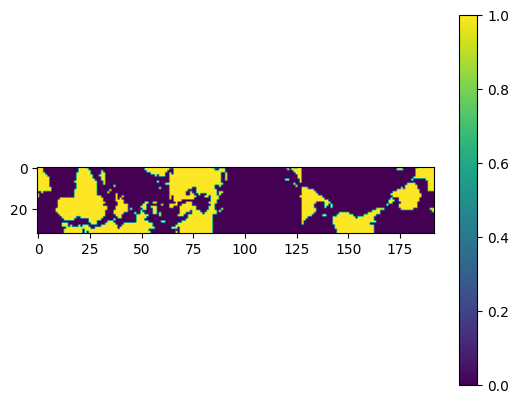

In [30]:
plt.imshow(1. -mask_ocean_2)
plt.colorbar()

端の行、列にある陸水に注意

まだ3枚め(第64列〜第95列)に陸水がある。これを消す。

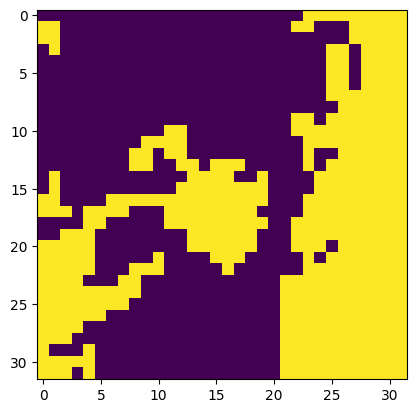

In [31]:
mask_ocean_partial = mask_ocean[:,64:96]
plt.imshow(mask_ocean_partial)

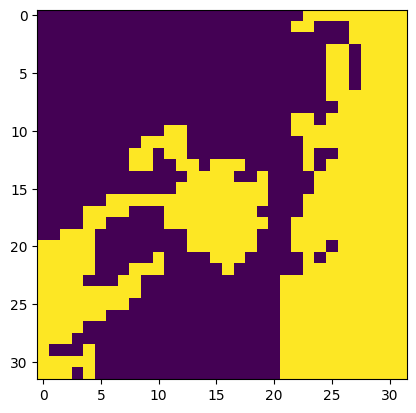

In [32]:
# 仮定：bathymetry = 海底の標高 [m]（例：0より小さいと海）
wet_mask_partial = (mask_ocean_partial ==1.)  # shape = (lat, lon)

# 外洋に接続している海を識別するための "種"：端に接している海
seed = np.zeros_like(wet_mask_partial, dtype=bool)
# seed[0, :] = wet_mask[0, :]
# seed[-1, :] = wet_mask[-1, :]
# seed[:, 0] = wet_mask[:, 0]
# seed[:, -1] = wet_mask[:, -1]
# # seed[18,78] = wet_mask[18,78] #北極海
seed[15,15] = wet_mask_partial[15,15]
seed[-1,-1] =wet_mask_partial[-1,-1]
# Flood fill: 外洋に繋がる海を True に
mask_ocean_partial = binary_propagation(seed, mask=wet_mask_partial)
plt.imshow(mask_ocean_partial)

In [33]:
mask_ocean[:,64:96] = mask_ocean_partial

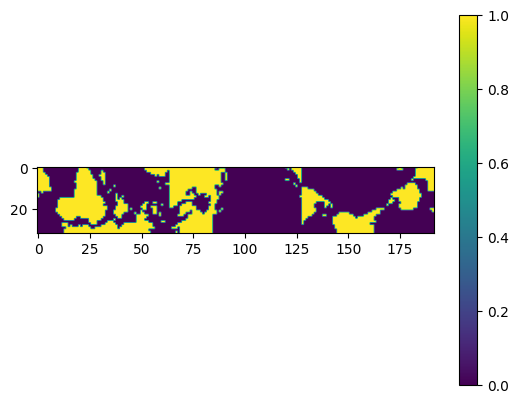

In [34]:
mask_land=1. -mask_ocean

plt.imshow(mask_land)
plt.colorbar()

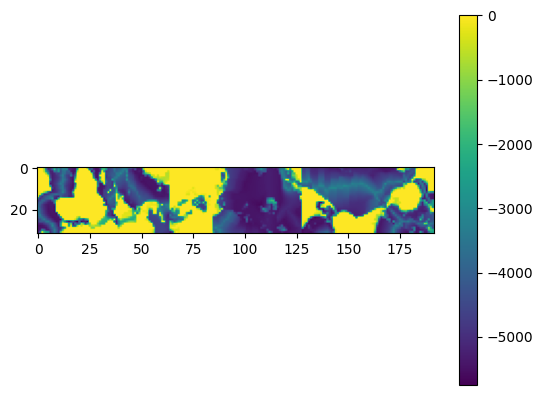

In [35]:
bathy_data *= mask_ocean
plt.imshow(bathy_data,vmax=0.
        #    , norm=TwoSlopeNorm(vmax=0.,vmin=-5200)
           )  # or shading='gouraud'
plt.colorbar()

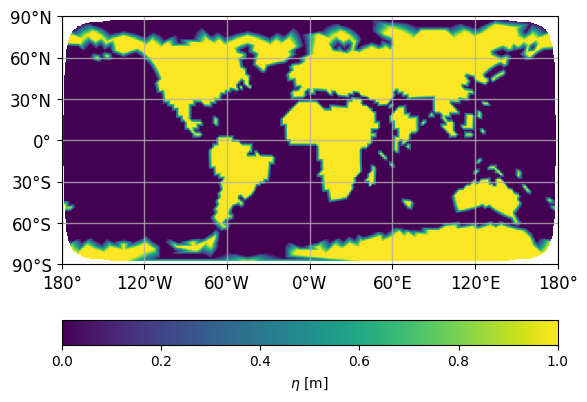

In [36]:
triang = tri.Triangulation(XC.flatten(), YC.flatten())
    
data = mask_land.copy()
# data[data==1.] = np.nan
# dmax = 1.

interpolator = tri.LinearTriInterpolator(triang, data.flatten())
bathy_data_regrid = interpolator(lon, lat)

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon,lat, bathy_data_regrid#, vmin=-500, vmax= 0#, cmap=cmocean.cm.deep_r
                   )

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
cb.set_label("$\eta$ [m]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

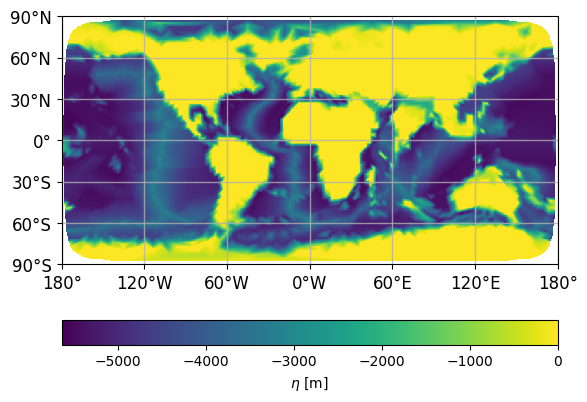

In [37]:
triang = tri.Triangulation(XC.flatten(), YC.flatten())
    
data = bathy_data
# dmax = 1.

interpolator = tri.LinearTriInterpolator(triang, data.flatten())
bathy_data_regrid = interpolator(lon, lat)

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon,lat, bathy_data_regrid#, vmin=-500, vmax= 0#, cmap=cmocean.cm.deep_r
                   )

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
cb.set_label("$\eta$ [m]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

array([0.00000000e+00, 5.57630683e-01, 8.22126221e-01, ...,
       2.41928276e+03, 3.34339150e+03, 3.42190273e+03])

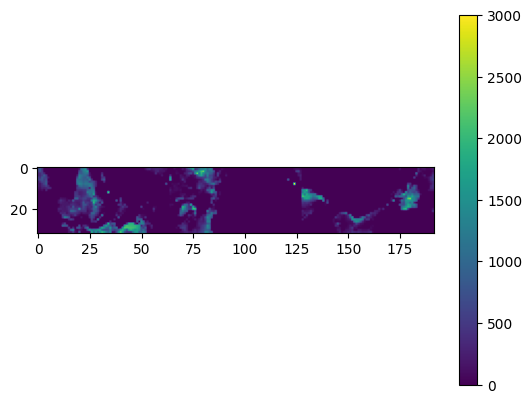

In [38]:
topo_data = regrid_data(lonlat,XCYC, top_indices_lonlat_to_XCYC,top_norms_lonlat_to_XCYC,bathytopo_raw,p=1.)
topo_data[topo_data<0.] = 0.
topo_data[mask_land==0.] = 0.

topo_data[(topo_data<=0.) & (mask_land==1.)] =np.unique(topo_data)[2]

plt.imshow(topo_data, vmax=3000, vmin=0.)
plt.colorbar()

np.unique(topo_data)


In [39]:
np.unique(bathy_data)

array([-5749.36397831, -5675.62445199, -5674.83076084, ...,
         -50.38276452,   -50.        ,     0.        ])

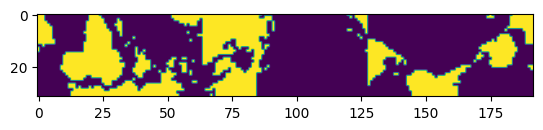

In [40]:
plt.imshow(bathy_data==0.)

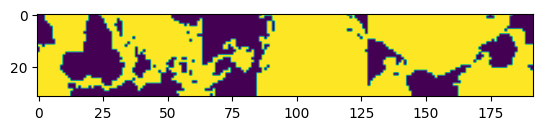

In [41]:
plt.imshow(topo_data==0.)


In [42]:
# np.argwhere((mask_land==0.) &  (bathy_data==0.))
np.argwhere((topo_data==0.) &  (bathy_data==0.))


array([], shape=(0, 2), dtype=int64)

In [43]:
# mask_land[30,19] =1.
# mask_land[2,69] =1.

# bathy_data[30,19] = 0.
# bathy_data[2,69] = 0.

# topo_data[30,19] = 1.e-2
# topo_data[2,69] = 1.e-2



In [44]:
fileloc_to_write_ocn


'/home/tsuribeh/MITgcm/cases_tsuribeh_master/Ex3.cpl_CTRL/input_ocn/'

In [45]:
mask_land_2 = topo_data>0. #確認用
print(np.unique(mask_land - mask_land_2))

#自分で好きに設定
filename_bathy = 'bathy.St36Ma_CS32.bin'
mit.writebin(fileloc_to_write_ocn+filename_bathy, bathy_data, dataprec='float64')

filename_topo = 'topo.St36Ma_CS32.bin'
mit.writebin(fileloc_to_write_atm+filename_topo, topo_data, dataprec='float64')
fillname_LandFile = 'landFrc.St36Ma_CS32.bin'

mit.writebin(fileloc_to_write_atm+fillname_LandFile, mask_land, dataprec='float64')


[0.]


2. Runoffデータ

In [46]:
land_indices = np.where(mask_land == 1.)
ocn_indices = np.where(mask_land == 0.)
land_indices[0]
land_indices[1]


array([  0,   1,   2, ..., 160, 161, 162])

In [47]:
# 陸と海の経度・緯度を抽出
XC_land = XC[land_indices]
YC_land = YC[land_indices]
XC_ocn = XC[ocn_indices]
YC_ocn = YC[ocn_indices]

# 3D座標に変換
ocn_xyz = np.array(lonlat_to_xyz(XC_ocn, YC_ocn)).T  # shape: (N_ocn, 3)
land_xyz = np.array(lonlat_to_xyz(XC_land, YC_land)).T  # shape: (N_land, 3)

# 海点からKDTree構築
tree = cKDTree(ocn_xyz)
n_runOff = 2
# 陸点から近傍のn_runOff個の海点を検索
distances, indices = tree.query(land_xyz, k=n_runOff)

nearest_ocn_indices_0 = np.empty((len(land_indices[0]), n_runOff), dtype=int)
nearest_ocn_indices_1 = np.empty((len(land_indices[0]), n_runOff), dtype=int)

for j in range(n_runOff):
    nearest_ocn_indices_0[:, j] = ocn_indices[0][indices[:, j]]
    nearest_ocn_indices_1[:, j] = ocn_indices[1][indices[:, j]]

for i in range(5):
    for j in range(n_runOff):
        print(f"Land index = ({land_indices[0][i]}, {land_indices[1][i]}) -> "
              f"Nearest ocean index = ({nearest_ocn_indices_0[i, j]}, {nearest_ocn_indices_1[i, j]}) "
              f"Distance ≈ {distances[i, j]:.4f}")


Land index = (0, 0) -> Nearest ocean index = (0, 3) Distance ≈ 0.0791
Land index = (0, 0) -> Nearest ocean index = (31, 163) Distance ≈ 0.0826
Land index = (0, 1) -> Nearest ocean index = (0, 3) Distance ≈ 0.0574
Land index = (0, 1) -> Nearest ocean index = (31, 163) Distance ≈ 0.0638
Land index = (0, 2) -> Nearest ocean index = (0, 3) Distance ≈ 0.0306
Land index = (0, 2) -> Nearest ocean index = (31, 163) Distance ≈ 0.0431
Land index = (0, 20) -> Nearest ocean index = (31, 180) Distance ≈ 0.0455
Land index = (0, 20) -> Nearest ocean index = (0, 19) Distance ≈ 0.0459
Land index = (0, 21) -> Nearest ocean index = (31, 181) Distance ≈ 0.0446
Land index = (0, 21) -> Nearest ocean index = (31, 182) Distance ≈ 0.0624


runOffMapSize=(landの点の数)*n_runOffとする

In [48]:
runOffMapSize = len(land_indices[0]) * n_runOff
runOffMapFile = np.empty((runOffMapSize,3))
Nx_atm = XC.shape[1]
Nx_ocn = XC.shape[1]
runOffMapSize

3836

In [49]:
i=0
for i in range(len(land_indices[0])):
    for j in range(n_runOff):
        idx_out = i * n_runOff + j
        ijROatm = land_indices[0][i] * Nx_atm + land_indices[1][i] + 1
        ijROocn = nearest_ocn_indices_0[i, j] * Nx_ocn + nearest_ocn_indices_1[i, j] + 1
        runOffMapFile[idx_out, 0] = ijROatm
        runOffMapFile[idx_out, 1] = ijROocn
        runOffMapFile[idx_out, 2] = DS[land_indices[0][i], land_indices[1][i]] / n_runOff

#自分で好きに設定
filename_runOff = 'runOff_St36Ma_CS32_'+str(runOffMapSize)+'.bin'
mit.writebin(fileloc_to_write_cpl+filename_runOff, runOffMapFile, dataprec='float64')

3. 海洋の初期塩分, 水温

In [50]:
RC = mit.rdmds(fileloc_csgrid+'RC') 
RC

array([[[  -25.]],

       [[  -85.]],

       [[ -170.]],

       [[ -290.]],

       [[ -455.]],

       [[ -670.]],

       [[ -935.]],

       [[-1250.]],

       [[-1615.]],

       [[-2030.]],

       [[-2495.]],

       [[-3010.]],

       [[-3575.]],

       [[-4190.]],

       [[-4855.]]])

In [51]:
fileloc_WOA ="/home/tsuribeh/Forcing_data/World Ocean Atlas 2023/"

ds_S = xr.open_dataset(fileloc_WOA+'1_woa23_decav_s00_01.nc', decode_times=False)
ds_T = xr.open_dataset(fileloc_WOA+'1_woa23_decav_t00_01.nc',decode_times=False)
# S_decav = ds_S.variables["s_an"].values
# S_decav
ds_S

<xarray.Dataset> Size: 26MB
Dimensions:  (time: 1, depth: 102, lat: 180, lon: 360)
Coordinates:
  * time     (time) float32 4B 4.614e+03
  * depth    (depth) float32 408B 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    s_an     (time, depth, lat, lon) float32 26MB ...
    crs      int32 4B ...
Attributes: (12/46)
    Conventions:                     CF-1.6
    title:                           World Ocean Atlas 2023 : sea_water_pract...
    summary:                         Climatological mean salinity for the glo...
    references:                      Reagan, J.R., D. Seidov, Z. Wang, D. Duk...
    institution:                     NOAA National Centers for Environmental ...
    comment:                         Global Climatology as part of the World ...
    ...                              ...
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   https://www.ncei.noaa.gov/products/world...
    date_created:                    2024-01-28 
    date_modified:                   2024-01-28 
    History:                         Translated to CF-1.0 Conventions by Netc...

In [52]:
import numpy as np
import xarray as xr
from scipy.interpolate import interp1d

# データ読み込み
fileloc_WOA = "/home/tsuribeh/Forcing_data/World Ocean Atlas 2023/"
ds_S = xr.open_dataset(fileloc_WOA + '1_woa23_decav_s00_01.nc', decode_times=False)
ds_T = xr.open_dataset(fileloc_WOA + '1_woa23_decav_t00_01.nc', decode_times=False)

# データ取得
depth = -ds_S['depth'].values
lat = ds_S['lat'].values
lon = ds_S['lon'].values

S_data = ds_S['s_an'].values[0]  # (depth, lat, lon)
T_data = ds_T['t_an'].values[0]  # (depth, lat, lon)

# 面積重み（緯度方向のcos）
lat_rad = np.deg2rad(lat)
weights = np.cos(lat_rad)  # shape: (lat,)
weights_2d = weights[:, np.newaxis]  # shape: (lat, 1) → broadcast to (lat, lon)

# 欠損値を除いて面積加重平均（depthごとに）
def weighted_mean(data, weights):
    weighted_sum = np.nansum(data * weights, axis=(1,2))
    weights_sum = np.nansum(weights * (~np.isnan(data)), axis=(1,2))
    return weighted_sum / weights_sum

S_mean_profile = weighted_mean(S_data, weights_2d)
T_mean_profile = weighted_mean(T_data, weights_2d)

# 任意の深さRCに線形補間
RC = np.array([-25., -85., -170., -290., -455., -670., -935., -1250.,
               -1615., -2030., -2495., -3010., -3575., -4190., -4855.])

# 補間（欠損値除去）
valid_S = ~np.isnan(S_mean_profile)
valid_T = ~np.isnan(T_mean_profile)

fS = interp1d(depth[valid_S], S_mean_profile[valid_S], kind='linear',
              bounds_error=False, fill_value='extrapolate')
fT = interp1d(depth[valid_T], T_mean_profile[valid_T], kind='linear',
              bounds_error=False, fill_value='extrapolate')

S_interp = fS(RC)
T_interp = fT(RC)

# 結果表示
for i, rc in enumerate(RC):
    print(f"RC={rc:6.1f} m:  Salinity = {S_interp[i]:.2f},  Temperature = {T_interp[i]:.2f}")


RC= -25.0 m:  Salinity = 34.73,  Temperature = 17.95
RC= -85.0 m:  Salinity = 34.97,  Temperature = 15.68
RC=-170.0 m:  Salinity = 34.99,  Temperature = 12.69
RC=-290.0 m:  Salinity = 34.85,  Temperature = 10.12
RC=-455.0 m:  Salinity = 34.69,  Temperature = 7.88
RC=-670.0 m:  Salinity = 34.59,  Temperature = 6.00
RC=-935.0 m:  Salinity = 34.59,  Temperature = 4.52
RC=-1250.0 m:  Salinity = 34.65,  Temperature = 3.51
RC=-1615.0 m:  Salinity = 34.70,  Temperature = 2.80
RC=-2030.0 m:  Salinity = 34.73,  Temperature = 2.31
RC=-2495.0 m:  Salinity = 34.75,  Temperature = 1.97
RC=-3010.0 m:  Salinity = 34.74,  Temperature = 1.72
RC=-3575.0 m:  Salinity = 34.74,  Temperature = 1.51
RC=-4190.0 m:  Salinity = 34.73,  Temperature = 1.34
RC=-4855.0 m:  Salinity = 34.73,  Temperature = 1.32


現在の深層水温は約1.5度。始新世後期の深層水温は約6度だった(Zachos et al,2001など)ので、初期状態では各層に4.5度加える。塩分はそのまま用いる。

In [53]:
T_interp[0]

17.945907589048147

In [54]:
#海洋初期水温場の作成
filename_ocniniT = 'iniT.Ex3.cpl_CTRL_CS32_15k.bin'
iniT_data = np.ones((15,32,192))
k=0
for k in range(15):
    iniT_data[k] = (T_interp[k] + 4.5)

mit.writebin(fileloc_to_write_ocn+filename_ocniniT, iniT_data, dataprec='float64')

In [55]:
#海洋初期塩分場の作成
filename_ocniniS = 'iniS.Ex3.cpl_CTRL_CS32_15k.bin'
iniS_data = np.ones((15,32,192))
k=0
for k in range(15):
    iniS_data[k] = (S_interp[k])

mit.writebin(fileloc_to_write_ocn+filename_ocniniS, iniS_data, dataprec='float64')

４.大気の初期比湿、温位

In [56]:
fileloc_csgrid_atm = '/home/tsuribeh/MITgcm/cases_tsuribeh_bachelor/cpl_aim+ocn_cs32/rank_2/'
RC_atm = mit.rdmds(fileloc_csgrid_atm+'RC')
print(RC_atm)

fileloc_Spehum = '/home/tsuribeh/Forcing_data/ERA5/Monthly average SpeHum&Temp/9194e14c506c432bc10850fcabcff619.grib'
import pygrib
grbs = pygrib.open(fileloc_Spehum)




[[[95000.]]

 [[77500.]]

 [[50000.]]

 [[25000.]]

 [[ 7500.]]]


In [57]:
# 各月12×10年＝120個あると仮定
n_time = 120

# 任意の subsample 係数
subsample = 10

# 比湿をすべて抽出（1つ目のメッセージで形を確認）
msgs = grbs.select(name='Specific humidity')


In [58]:
msgs

[1:Specific humidity:kg kg**-1 (avgua):regular_ll:isobaricInhPa:level 70:fcst time 0 hrs (avgua):from 194001010000,
 3:Specific humidity:kg kg**-1 (avgua):regular_ll:isobaricInhPa:level 250:fcst time 0 hrs (avgua):from 194001010000,
 5:Specific humidity:kg kg**-1 (avgua):regular_ll:isobaricInhPa:level 500:fcst time 0 hrs (avgua):from 194001010000,
 7:Specific humidity:kg kg**-1 (avgua):regular_ll:isobaricInhPa:level 775:fcst time 0 hrs (avgua):from 194001010000,
 9:Specific humidity:kg kg**-1 (avgua):regular_ll:isobaricInhPa:level 950:fcst time 0 hrs (avgua):from 194001010000,
 11:Specific humidity:kg kg**-1 (avgua):regular_ll:isobaricInhPa:level 70:fcst time 0 hrs (avgua):from 194002010000,
 13:Specific humidity:kg kg**-1 (avgua):regular_ll:isobaricInhPa:level 250:fcst time 0 hrs (avgua):from 194002010000,
 15:Specific humidity:kg kg**-1 (avgua):regular_ll:isobaricInhPa:level 500:fcst time 0 hrs (avgua):from 194002010000,
 17:Specific humidity:kg kg**-1 (avgua):regular_ll:isobaricInhP

In [59]:
sample = msgs[0]
lat2d, lon2d = sample.latlons()
lat2d = lat2d[::subsample, ::subsample]
lon2d = lon2d[::subsample, ::subsample]
nlat, nlon = lat2d.shape

# 面積重みを緯度から計算

dlat = np.deg2rad(np.abs(lat2d[1, 0] - lat2d[0, 0]))
dlon = np.deg2rad(np.abs(lon2d[0, 1] - lon2d[0, 0]))
area_weights = np.cos(np.deg2rad(lat2d)) * dlat * dlon

# すべての時間・レベルで平均をとる（レベル数は msg 中でループ確認）
levels = sorted(set([m.level for m in msgs]))
n_levels = len(levels)
specific_humidity_mean = np.zeros(n_levels)

for i, lev in enumerate(levels):
    lev_msgs = [m for m in msgs if m.level == lev]
    acc = np.zeros_like(lat2d)
    for m in lev_msgs:
        data = m.values[::subsample, ::subsample]
        acc += data
    acc /= len(lev_msgs)
    # 面積重み付き平均
    weighted_mean = np.sum(acc * area_weights) / np.sum(area_weights)
    specific_humidity_mean[i] = weighted_mean


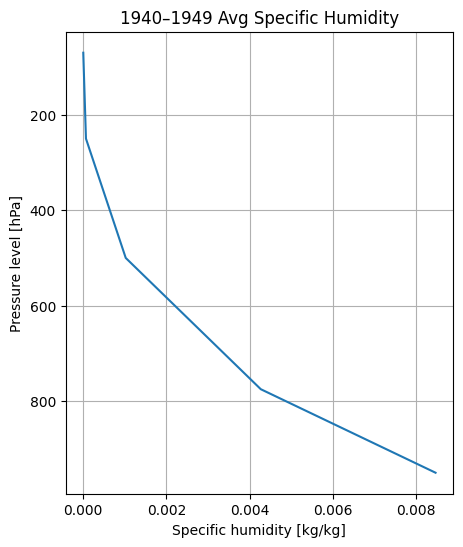

In [60]:

# プロット
plt.figure(figsize=(5, 6))
plt.plot(specific_humidity_mean, levels)
plt.xlabel("Specific humidity [kg/kg]")
plt.ylabel("Pressure level [hPa]")
plt.title("1940–1949 Avg Specific Humidity")
plt.gca().invert_yaxis()
plt.grid()
plt.show()

In [61]:
levels#各層の圧力

[70, 250, 500, 775, 950]

In [62]:
specific_humidity_mean

array([2.73990224e-06, 6.75097918e-05, 1.02347451e-03, 4.26867943e-03,
       8.46848820e-03])

MITgcmは地表が第０成分のため、逆順に
単位もkg/kgからg/kgに

In [63]:
iniS_atm = specific_humidity_mean[::-1]*1000.

In [64]:
fileloc_to_write_atm

'/home/tsuribeh/MITgcm/cases_tsuribeh_master/Ex3.cpl_CTRL/input_atm/'

In [65]:
iniS_atm

array([8.46848820e+00, 4.26867943e+00, 1.02347451e+00, 6.75097918e-02,
       2.73990224e-03])

In [66]:
#大気初期比湿場の作成
filename_atminiS = 'iniSAtm.Ex3.cpl_CTRL_CS32_5k.bin'
iniS_atm_data = np.ones((5,32,192))
k=0
for k in range(5):
    iniS_atm_data *= iniS_atm[k]
mit.writebin(fileloc_to_write_atm+filename_atminiS, iniS_atm_data, dataprec='float64')


In [67]:
# 気温をすべて抽出（1つ目のメッセージで形を確認）
msgs2 = grbs.select(name='Temperature')


In [68]:
sample2 = msgs2[0]
lat2d, lon2d = sample2.latlons()
lat2d = lat2d[::subsample, ::subsample]
lon2d = lon2d[::subsample, ::subsample]
nlat, nlon = lat2d.shape

# 面積重みを緯度から計算

dlat = np.deg2rad(np.abs(lat2d[1, 0] - lat2d[0, 0]))
dlon = np.deg2rad(np.abs(lon2d[0, 1] - lon2d[0, 0]))
area_weights = np.cos(np.deg2rad(lat2d)) * dlat * dlon

# すべての時間・レベルで平均をとる（レベル数は msg 中でループ確認）
levels = sorted(set([m.level for m in msgs2]))
n_levels = len(levels)
temperature_mean = np.zeros(n_levels)

for i, lev in enumerate(levels):
    lev_msgs = [m for m in msgs2 if m.level == lev]
    acc = np.zeros_like(lat2d)
    for m in lev_msgs:
        data = m.values[::subsample, ::subsample]
        acc += data
    acc /= len(lev_msgs)
    # 面積重み付き平均
    weighted_mean = np.sum(acc * area_weights) / np.sum(area_weights)
    temperature_mean[i] = weighted_mean


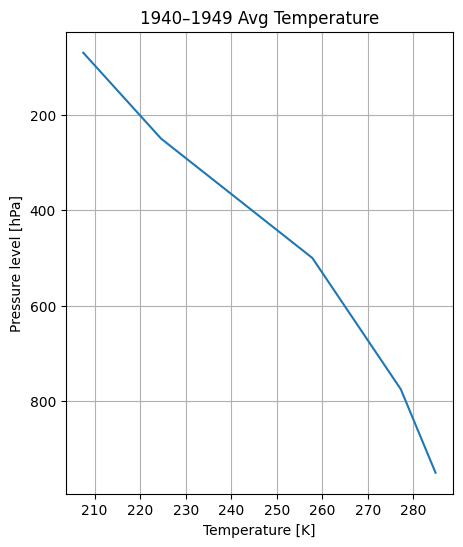

In [69]:

# プロット
plt.figure(figsize=(5, 6))
plt.plot(temperature_mean, levels)
plt.xlabel("Temperature [K]")
plt.ylabel("Pressure level [hPa]")
plt.title("1940–1949 Avg Temperature")
plt.gca().invert_yaxis()
plt.grid()
plt.show()

データは温度。これを温位に変換する。

In [70]:
Cp = 1004 #定圧比熱 [J/kg/K]
Rgas = 287 #乾燥空気の気体定数 [J/kg/K]
P0 = 1000 #基準気圧 [hPa]
Theta = np.zeros_like(temperature_mean)
k=0
for k in range(5):
    Theta[k] = temperature_mean[k] * (P0/levels[k])**(Rgas/Cp)

In [71]:
Theta

array([443.76483951, 333.80875461, 314.30219941, 298.18783001,
       289.0794846 ])

In [72]:
DP = np.array([100.e2, 250.e2, 300.e2, 200.e2,150.e2])
PF = (1000.e2 - np.cumsum(DP))/1.e2
PF = np.append(1000., PF)
PC = (PF[1:] + PF[:-1])/2. #セル中心の圧力
print(PC)
print(levels)

[950. 775. 500. 250.  75.]
[70, 250, 500, 775, 950]


tRef=289.6, 298.1, 314.5, 335.8, 437.4,
と変わらない(437.4と443．7の差は75hPaと70hPaの差に起因)ので、tRefを与えることとする

In [73]:
#大気初期気温場の作成
filename_atminiT = 'iniTAtm.Ex3.cpl_CTRL_CS32_5k.bin'
iniT_atm = np.array([289.6, 298.1, 314.5, 335.8, 437.4]) #tRefと同じ
iniT_atm_data = np.ones((5,32,192))
k=0
for k in range(5):
    iniT_atm_data *= iniT_atm[k]-273.15 #Kを℃に
mit.writebin(fileloc_to_write_atm+filename_atminiT, iniT_atm_data, dataprec='float64')


5. 陸面の初期条件（地表温度, 地下水の割合, 積雪高）

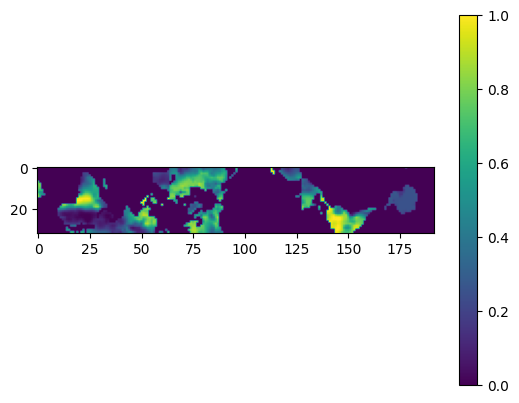

In [123]:
# land_groundW_otehon =  mit.rdmds('/home/tsuribeh/MITgcm/verification/cpl_aim+ocn/rank_2/land_groundW',40)
land_groundW_otehon =  mit.readbin('/home/tsuribeh/MITgcm/verification/cpl_aim+ocn/rank_2/land_grW_ini.mn.bin',(2,32,192),dataprec='float64')

plt.imshow(land_groundW_otehon[1])
plt.colorbar()


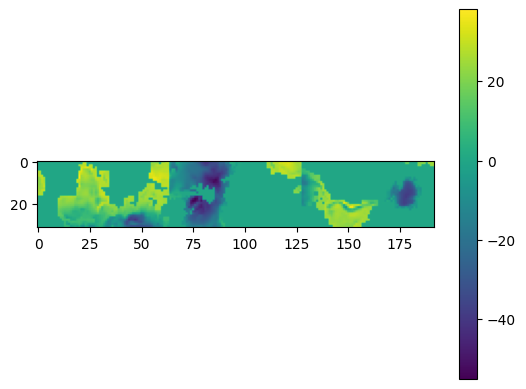

In [124]:
# land_groundT_otehon =  mit.rdmds('/home/tsuribeh/MITgcm/verification/cpl_aim+ocn/rank_2/land_groundT',40)
land_groundT_otehon =  mit.readbin('/home/tsuribeh/MITgcm/verification/cpl_aim+ocn/rank_2/land_grT_ini.cpl.bin',(2,32,192),dataprec='float64')

plt.imshow(land_groundT_otehon[0])
plt.colorbar()


0.3360688373969481
0.32788149080639994


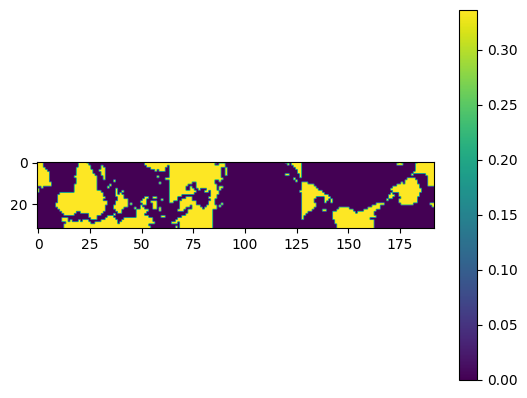

In [125]:
groundW_mean =np.ones((2,32,192))*mask_land

for k in range(2):
    groundW_mean[k] *= np.sum(DS * land_groundW_otehon[k]*mask_land)/ np.sum(DS*mask_land)
    print(np.sum(DS * land_groundW_otehon[k]*mask_land)/ np.sum(DS*mask_land))
plt.imshow(groundW_mean[0])
plt.colorbar()
filename_iniGrW = 'iniGrW.Ex3.cpl_CTRL_CS32_2k.bin'
mit.writebin(fileloc_to_write_atm+filename_iniGrW, groundW_mean, dataprec='float64')


-2.1480862627016175
3.6448214018881853


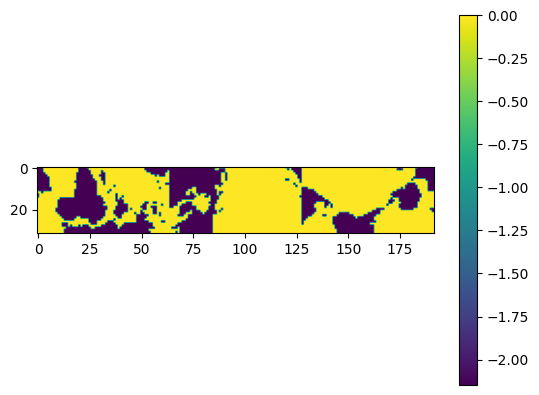

In [126]:
groundT_mean =np.ones((2,32,192))*mask_land
for k in range(2):
    groundT_mean[k] *= np.sum(DS * land_groundT_otehon[k]*mask_land)/ np.sum(DS*mask_land)
    print(np.sum(DS * land_groundT_otehon[k]*mask_land)/ np.sum(DS*mask_land))
plt.imshow(groundT_mean[0])
plt.colorbar()
filename_iniGrT = 'iniGrT.Ex3.cpl_CTRL_CS32_2k.bin'
mit.writebin(fileloc_to_write_atm+filename_iniGrT, groundT_mean, dataprec='float64')

In [127]:
filename_iniSnw = 'iniSnw.Ex3.cpl_CTRL_CS32.bin'
mit.writebin(fileloc_to_write_atm+filename_iniSnw, np.zeros((32,192)), dataprec='float64')

結合モデルの場合はここまででOK

In [ ]:

# filename_hydrogTheta = 'hydrogTheta_St50Ma_cs32x15.bin'
# filename_hydrogSalt = 'hydrogSalt_St50Ma_cs32x15.bin' #might work without adapting to each bathies, but adapted in default setting
# filename_TauX ='trenberth_TauX_polar_averaged_sym.bin' #not depend on bathy
# filename_TauY ='trenberth_TauY_averaged_antisym.bin' #not depend on bathy
# filename_SST ='lev_SST_EarlyEoceneSeason_St50Ma_cs32x2seasons.bin'
# # filename_SST ='lev_SST_sym_Pm38Ma_cs32x12m.bin'
# filename_SSS ='lev_SSS_polar_sym_tuned_St50Ma_cs32x2seasons.bin'

In [ ]:
# fileloc_TauX = '/home/tsuribeh/Forcing_data/J-OFURO3/dias/data/J-OFURO3_V1_2/MONTHLY/HR/TAUX/'
# fileloc_TauY = '/home/tsuribeh/Forcing_data/J-OFURO3/dias/data/J-OFURO3_V1_2/MONTHLY/HR/TAUY/'

# fileloc_Clim = '/home/tsuribeh/Forcing_data/J-OFURO3/dias/data/J-OFURO3_V1_2/CLIMATOLOGY/'


In [ ]:
# # すべてのnetCDFファイルを読み込む
# file_list_TauX = sorted(glob.glob(fileloc_TauX+"J-OFURO3_TAUX_V1.2_MONTHLY_HR_*.nc"))
# file_list_TauY = sorted(glob.glob(fileloc_TauY+"J-OFURO3_TAUY_V1.2_MONTHLY_HR_*.nc"))


# # すべての年をまとめて読み込み
# # ds_all_years = xr.open_mfdataset(file_list_TauX, combine='by_coords')
# ds_all_years = xr.open_mfdataset(file_list_TauY, combine='by_coords')


# # time変数がdatetime64であることを確認し、なければ変換
# if not np.issubdtype(ds_all_years.time.dtype, np.datetime64):
#     ds_all_years['time'] = xr.cftime_range(start='1900-01', periods=ds_all_years.time.size, freq='MS')

# # 月ごとの平均（climatology）を計算
# climatology = ds_all_years.groupby('time.month').mean('time')

# # 必要なら保存
# # climatology.to_netcdf(fileloc_to_write+"TauX_J-OFULO3_1991_2011_climatology.nc")
# # climatology.to_netcdf(fileloc_to_write+"TauY_J-OFULO3_1991_2011_climatology.nc")


In [ ]:
# TauX_climatology = xr.open_dataset(fileloc_Clim+"TauX_J-OFURO3_1991_2011_climatology.nc")

# TauY_climatology = xr.open_dataset(fileloc_Clim+"TauY_J-OFURO3_1991_2011_climatology.nc")


In [ ]:
# TauY_np = TauY_climatology['TAUY'].values  # shape: (12, 720, 1440)
# TauX_np = TauX_climatology['TAUX'].values  # shape: (12, 720, 1440)



In [ ]:
# lat_np = TauY_climatology['latitude'].values  # shape: (720,)
# lon_np = TauY_climatology['longitude'].values  # shape: (1440,)


In [ ]:
# TauX_yrmean = np.mean(TauX_np, axis=0) #年平均
# TauY_yrmean = np.mean(TauY_np, axis=0) #年平均


In [ ]:
# TauX_znyrmean = np.empty_like(TauX_yrmean)
# for i in range(len(lon_np)):
#     TauX_znyrmean[:,i] = np.nanmean(TauX_yrmean, axis=1)
    

/tmp/ipykernel_1347675/1495014142.py:3: RuntimeWarning: Mean of empty slice
  TauX_znyrmean[:,i] = np.nanmean(TauX_yrmean, axis=1)


In [ ]:
# TauY_znyrmean = np.empty_like(TauY_yrmean)
# for i in range(len(lon_np)):
#     TauY_znyrmean[:,i] = np.nanmean(TauY_yrmean, axis=1)
    

/tmp/ipykernel_1347675/2754889207.py:3: RuntimeWarning: Mean of empty slice
  TauY_znyrmean[:,i] = np.nanmean(TauY_yrmean, axis=1)


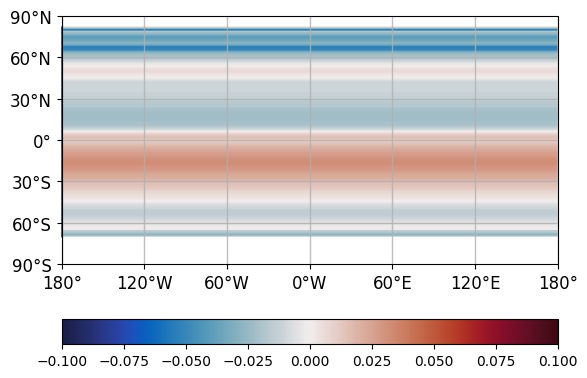

In [ ]:
# data = TauY_znyrmean

# dmax= max(np.max(data), -np.min(data))

# fig=plt.figure()
# ax = plt.axes(projection=ccrs.PlateCarree())
# cf = ax.pcolormesh(lon_np,lat_np, data, vmax= dmax, vmin =-dmax
#    ,cmap=  cmocean.cm.balance
#                    )

# # カラーバーを追加
# cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
# # cb.set_label("Temperature [${}^\circ\\mathrm{C}$]")

# #グリッドと軸目盛を描く緯度経度を設定するための配列
# dlon,dlat=60,30
# xticks=np.arange(-180,180.1,dlon)
# yticks=np.arange(-90,90.1,dlat)

# #グリッド線を引く
# gl = ax.gridlines(crs=ccrs.PlateCarree()
#          , draw_labels=False
#          , linewidth=1, alpha=0.8)
# gl.xlocator = mticker.FixedLocator(xticks)    
# gl.ylocator = mticker.FixedLocator(yticks)
# #目盛を描く緯度経度の値を設定
# ax.set_xticks(xticks,crs=ccrs.PlateCarree())
# ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# # 目盛の表示形式を度数表記にする    
# latfmt=LatitudeFormatter()
# lonfmt=LongitudeFormatter(zero_direction_label=True)
# ax.xaxis.set_major_formatter(lonfmt)
# ax.yaxis.set_major_formatter(latfmt)
# #目盛のサイズを指定
# ax.axes.tick_params(labelsize=12)

In [ ]:
# #Directory for cs grid
# fileloc_csgrid = '/home/tsuribeh/MITgcm/cases_tsuribeh_bachelor/cpl_aim+ocn_cs32/rank_1/'
# # CSグリッドデータの読み込み
# XC = mit.mds.rdmds(fileloc_csgrid+'XC') #longitude at cell center
# YC = mit.mds.rdmds(fileloc_csgrid+'YC') #latitude at cell center
# XG = mit.mds.rdmds(fileloc_csgrid+'XG')
# YG = mit.mds.rdmds(fileloc_csgrid+'YG')
# # RC = mit.mds.rdmds(fileloc_csgrid+'RC')  # セル中心の深さ can be changed
# # RF = mit.mds.rdmds(fileloc_csgrid+'RF')  # セル境界の深さ can be changed

# # fileloc_latlondata ='/home/tsuribeh/MITgcm/cases_tsuribeh/global_ocean.cs32x15_originalbathy/input/latlon_inputdata/'

# XCYC = np.stack([XC,YC],axis=2)
# XGYG = np.stack([XG,YG],axis=2)

# lon,lat = np.meshgrid(lon_np,lat_np)
# lonlat = np.stack([lon,lat],axis=2)

# #compute indice and norm for regridding
# top_indices_XCYC_to_lonlat, top_norms_XCYC_to_lonlat = calculate_top_l_indices_and_norms_ckdtree(XCYC, lonlat, l=4)
# top_indices_lonlat_to_XCYC, top_norms_lonlat_to_XCYC = calculate_top_l_indices_and_norms_ckdtree(lonlat, XCYC, l=4)


KeyboardInterrupt: 

In [ ]:
# TauX_regrid= regrid_data(lonlat, XCYC, top_indices_lonlat_to_XCYC,top_norms_XCYC_to_lonlat,TauX_znyrmean.astype('<f8'),p=2.) 
# TauY_regrid= regrid_data(lonlat, XCYC, top_indices_lonlat_to_XCYC,top_norms_XCYC_to_lonlat,TauY_znyrmean.astype('<f8'),p=2.) 


In [ ]:
# TauX_regrid[np.isnan(TauX_regrid)] =0.
# TauY_regrid[np.isnan(TauY_regrid)] =0.


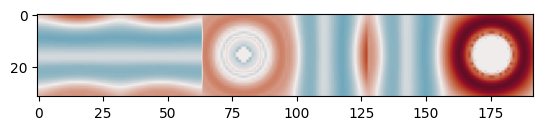

In [ ]:
# plt.imshow(TauX_regrid, cmap=cmocean.cm.balance,vmax=0.2, vmin=-0.2)

In [ ]:
# fileloc_to_write = '/home/tsuribeh/MITgcm/cases_tsuribeh_master/St50Ma_OCN/input/'

In [ ]:
# TauX_to_write = np.empty((12,32,192))
# TauY_to_write = np.empty((12,32,192))
# TauX_to_write[:] = TauX_regrid
# TauY_to_write[:] = TauY_regrid 


In [ ]:
# mit.writebin(fileloc_to_write+'J-OFURO_TauX_steady.CS32.bin',TauX_to_write, dataprec='float64' )
# mit.writebin(fileloc_to_write+'J-OFURO_TauY_steady.CS32.bin',TauY_to_write, dataprec='float64' )


In [ ]:
# np.unique(np.isnan(TauX_to_write))

array([False])